# Ada - Milestone 2





## Installations

In [ ]:
!pip install pandas==1.0.5

In [ ]:
!pip install tqdm

In [4]:
!pip install newspaper3k

     |████████████████████████████████| 211 kB 8.5 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 7.4 MB 32.0 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=109db88ecd21e34873c74bc9bfbd9fd8a0cb108e0b7104f7fc78b2c78f52cde2
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3356 sha256=9bc4934699b3fd89acebf2fb4a858ad16562633c87cc60926b14f5e5ca937655
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398405 sha256=6e5d9c1cf3317a18d43e1c22f539418aa0846485331c1e1eac7b9e1f69a65abc
  Stored in directory: /root/.cache/pip/wheels/4c/91/46/3c208287b726df325a597957432

## Importations

In [5]:
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import bz2
import json
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt') # needed for Article
from newspaper import Article

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The data are too big to have them locally. We thus use google drive to manipulate our data.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Speaker_attribute Dataset


We first get the parquet file used to describe our data. The table contains the name of a speaker with his aliases, his gender, birth date, occupation, religion, ethnic group, politic orientation, party academical degree and his nationality. 
The link to our dataset will be represented by the column id. This column contains the wikidata identifier of our speaker.

In [ ]:
path_parquet = '/content/drive/MyDrive/ADA/project/Project datasets/speaker_attributes.parquet'
parquet = pd.read_parquet(path_parquet)

In [ ]:
# we only keep the features that are of interest for us
parquet = parquet[['date_of_birth', 'gender', 'occupation', 'id', 'label']]

Here is what our dataset looks like:

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
193529,[+1963-11-07T00:00:00Z],[Q6581097],[Q177220],Q7206805,Joey Tang Kin Ming
1309439,[+1956-12-12T00:00:00Z],[Q6581072],[Q1028181],Q6296828,Jovita Laurušaitė
8941316,[+2001-03-20T00:00:00Z],[Q6581097],[Q937857],Q98887333,Abduvohid Nematov
2125914,None,[Q6581072],[Q3391743],Q96996016,Catherine Azarkadon
6730964,None,None,None,Q102303854,Tore Dalenius


Then we process it in order to have the interesting data we want. We only keep the gender, the occupation, the id, the name of the speaker and the date of birth colomns and we check if all these lines are full.

In [ ]:
# Process parquet
nb_data_before = len(parquet)

# Remove rows with gender = None
parquet = parquet[~(parquet.gender.isnull())]
# Keep unique gender
parquet = parquet[parquet.gender.apply(lambda x: len(x)==1)]
nb_diff_data_gender = nb_data_before-len(parquet)

nb_data = len(parquet)
# Remove rows with occupation = None
parquet = parquet[~(parquet.occupation.isnull())]
nb_diff_data_occupation = nb_data-len(parquet)

nb_data = len(parquet)
# Remove rows with date_of_birth = None
parquet = parquet[~(parquet.date_of_birth.isnull())]
# Keep only unique date of birth
parquet = parquet[parquet.date_of_birth.apply(lambda x: len(x)==1)]
nb_diff_data_date_of_birth = nb_data-len(parquet)
# Keep only the year of birth the month and day are not relevant in terms of age
parquet.date_of_birth = parquet.date_of_birth.apply(lambda x : x[0][0:5])


# remove rows with label = None
parquet = parquet[~(parquet.label.isnull())]

#remove rows with id = None
parquet=parquet[~(parquet.id.isnull())]

Here is what our data looks like now.

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
4561525,+1988,[Q6581097],[Q937857],Q965729,Yosuke Saito
329999,+1975,[Q6581097],[Q36180],Q18195266,Jan Becker
6337622,+2000,[Q6581097],[Q937857],Q69147159,Melih Ibrahimoglu
133234,+1866,[Q6581072],"[Q82955, Q7019111]",Q4959147,Gertrud af Klintberg
4718933,+1931,[Q6581097],[Q11774891],Q7152254,Paul Masnick


Here is a small pie graph to see how much data we erased.

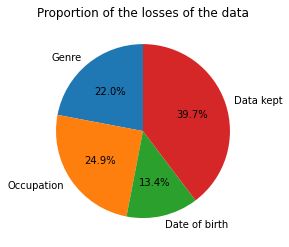

In [ ]:
gender_proportion = nb_diff_data_gender*100.0/nb_data_before
occupation_proportion = nb_diff_data_occupation*100.0/nb_data_before
date_of_birth_proportion = nb_diff_data_date_of_birth*100.0/nb_data_before
data_proportion = len(parquet)*100.0/nb_data_before

y = np.array([gender_proportion, occupation_proportion, date_of_birth_proportion,data_proportion])
labels = ["Genre", "Occupation", "Date of birth", "Data kept"]

plt.title('Proportion of the losses of the data')
plt.pie(y, labels = labels, startangle = 90, autopct='%1.1f%%')
plt.show() 

Here, we convert the columns _gender_ and _occupation_ into what their Qcode mean. To do so, we use the provided csv file wikidata_labels_descriptions_quotebank.csv.bz2 and a dictionnary containing textual descriptions of ids that are not in the provided file because they correspond to redirections.

In [ ]:
path_label_descriptions = '/content/drive/MyDrive/ADA/project/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
string_data = pd.read_csv(path_label_descriptions, compression='bz2', index_col='QID')
quids_redir = {'Q3268166': 'clinical psychologist', 'Q12014399': 'catholic priest', 'Q11819457': 'visual artist',
               'Q12334852': 'sailor', 'Q3186984': 'journalist', 'Q15991263': 'auctioneer', 'Q12455619': 'social worker',
               'Q1248362': 'director of a creative work', 'Q13365117': 'handball player', 'Q21550646': 'glass painter',
               'Q6363085': 'advocate', 'Q16287483': 'opinion journalist', 'Q13424794': 'computational scientist',
               'Q11815360': 'pediatrician', 'Q5568256': 'forester', 'Q6859927': 'lady-in-waiting', 'Q15145782': 'transgender female',
               'Q15145783': 'transgender male'}

In [ ]:
# convert wiki ids to strings ~28min
def convert_id_str(x):
  if (np.array(x) != None).all(): # x is a np.array by default but if None then just None so cast to array otherwise error on .all()
    strings = []
    for id in x:
      # id needs to be in string_data index otherwise error     
      try:
        strings.append(string_data.loc[id]['Label'])
      except KeyError:
        #print('Id: {} was not found in label_descriptions'.format(id))
        if id in quids_redir.keys():
          redirect = quids_redir[id]
          strings.append(redirect)
    return strings
  else:
    return None

parquet[['gender', 'occupation']] = parquet[['gender', 'occupation']].applymap(convert_id_str)

parquet.to_pickle('/content/drive/MyDrive/ADA/project/parquet_proc_str.pkl') 

In [ ]:
parquet = pd.read_pickle('/content/drive/MyDrive/ADA/project/parquet_proc_str.pkl')

Here is how the speaker attributes dataset finally looks like.

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
6284762,+1864,[female],[writer],Q63107159,Mara Antelling
81607,+1858,[male],"[poet, composer, stage actor]",Q2894407,Sigmund Mogulesko
1308888,+1923,[male],[cricketer],Q6281796,Joseph Burke
5763221,+1978,[male],[politician],Q3619095,Antonino Minardo
136983,+1893,[male],[baseball player],Q5093682,Chester Pittser


## Quotebank Dataset


First, we define our processing functions : process_probas and process_qchunk. 

The first one do is used to check if the probability of a speaker for a given quote is more than 70%. We chose that threshold because we want to avoid probabilities close to 0.5, because the odd to make a mistake is 1:1. We want to make sure that our speaker probability is not random. 
We use the second one to clean the data and form our final dataset.

In [ ]:
# Process probas attribute
def process_probas(speakers_probas): # In case the most probable speaker isn't the first one
  # Flatten probas into a single list
  flat = [item for sublist in speakers_probas for item in sublist]
  # Extract probs
  probas = [float(p) for i,p in enumerate(flat) if i%2]
  return (max(probas) > 0.7) # Return 1 if the max proba > 0.7



# Process samples by chunks
def process_qchunk(chunk, path): # Quotebank chunk
  rem = []

  # Drop rows where speaker==None
  initial_n = len(chunk)
  chunk = chunk[chunk.speaker != 'None']
  rem.append(initial_n-len(chunk)) 

  # Keep only quotes with very probable speaker
  initial_n = len(chunk)
  chunk = chunk[chunk.probas.apply(process_probas)] 
  rem.append(initial_n-len(chunk))

  # Keep only numOcurrences > 0 
  initial_n = len(chunk)
  chunk = chunk[chunk.numOccurrences > 0]
  rem.append(initial_n-len(chunk))

  # Keep only qid size=1
  initial_n = len(chunk)
  chunk = chunk[chunk.qids.apply(lambda x: len(x)==1)]
  rem.append(initial_n-len(chunk))

  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem

Here is where we extract the Quotebank dataset and use the functions defined above.

In [ ]:
# Processing by chunks
years = ['2020', '2019', '2018', '2017', '2016', '2015']

n_chunks = [0]*len(years)    # needed for read back
processing_steps = 4         # known speaker, very probable speaker, numOcurrences > 0, one single qid,
removed = np.zeros((len(years),processing_steps))
initial_n = [0]*len(years)

for i, year in zip(tqdm(range(len(years))), years):

  path_to_sfile = '/content/drive/MyDrive/ADA/Quotebank/quotes-'+year+'.json.bz2' 
  path_to_dfile = '/content/drive/MyDrive/ADA/quotes-'+year+'_processed.pkl' 

  df_reader = pd.read_json(path_to_sfile, lines=True, compression='bz2', chunksize=100000)
  for chunk in df_reader : 
    initial_n[i] += len(chunk)
    removed[i,:] += process_qchunk(chunk, path_to_dfile)
    n_chunks[i] += 1
  print(n_chunks[i])
  print('Year: {}  Inital number of samples: {}  Removed: {}  Total: {} '.format(year, initial_n[i], removed[i,:],
                                                                                 removed[i,:].sum()))

The resulting prints don't appear here because to gain time we processed different years on different computers in parallel, but we used the same code with the years list containing a single year so it's basically the same.

Here is a visualisation of the process of our data.

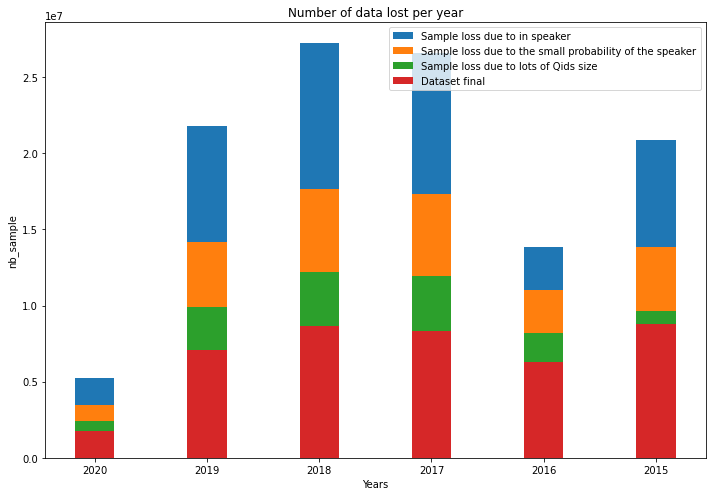

In [3]:
init_nb_sample = [5244449, 21763302, 27228451, 26611588, 13862129, 20874338]
nb_sample_none_speaker = [3443605, 14183294, 17670419, 17333298, 11035434, 13858038]
nb_sample_prob_speaker = [2419648, 9875076, 12185447, 11948347, 8208739, 9663107]
nb_sample_qid_size = [1743841, 7076288, 8623990, 8329693, 6286262, 8781475]
years = ['2020', '2019', '2018', '2017', '2016', '2015']

ind = np.arange(len(init_nb_sample))

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.bar(x=ind, height=init_nb_sample, width=0.35, align='center', label = 'Sample loss due to in speaker')
ax.bar(x=ind, height=nb_sample_none_speaker, width=0.35, align='center', label = 'Sample loss due to the small probability of the speaker')
ax.bar(x=ind, height=nb_sample_prob_speaker, width=0.35, align='center', label = 'Sample loss due to lots of Qids size')
ax.bar(x=ind, height=nb_sample_qid_size, width=0.35, align='center', label = 'Dataset final')


plt.xticks(ind, years)
plt.title('Number of data lost per year')
plt.legend()
plt.xlabel('Years')
plt.ylabel('nb_sample')
plt.tight_layout()
plt.show()

We can see that 2020 has much less quotes than the other years. Moreover, we see that we keep a third of our original data for our project.

We then extract the name of the author of the articles using the urls and determine his/her gender.


First we need to train a naive Bayes classifier from NLTK to obtain the gender of the author using the name_gender_dataset.csv made available by the Center for Machine Learning and Intelligent Systems of the University of California, Irvine.

In [ ]:
# importing name-gender dataset
df_names = pd.read_csv('/content/drive/MyDrive/ADA/project/name_gender_dataset.csv')
df_names = df_names[['Name', 'Gender']]
df_names

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M
...,...,...
147264,Zylenn,M
147265,Zymeon,M
147266,Zyndel,M
147267,Zyshan,M


In [ ]:
# checking dataset
# no None
print('Number of none present in names: {}  Number of none present in gender: {}'.format(
      df_names.Name.isnull().sum(), df_names.Gender.isnull().sum()))
# balanced
print(('Number of male names: {}  Number of female names: {}'.format(
      df_names.Gender=='M').sum(), (df_names.Gender=='F').sum()))
# only males and females
print('Only male/female genders ? :'.format(((df_names.Gender=='M').sum()+(df_names.Gender=='F').sum())==len(df_names)))

0 0
57520 89749
True


In [ ]:
# feature extractor
def gender_features(word):
  return {'last_letter':word[-1],
          'last_2letters':word[-2:]}

In [ ]:
# preparing a list of examples and corresponding class labels.
labeled_names = [(name, gender) for (name, gender) in zip(df_names.Name, df_names.Gender)]

# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]

# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = train_test_split(featuresets, test_size=0.25)

clf = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(clf, train_set))
print(nltk.classify.accuracy(clf, test_set))

0.7635874731781513
0.7603889401922972


To extract the name of the author of the article containing the quote, we use the newspaper3k library which provides an implementation of the author extractor that can be used easily. The gender of the authors will then be determined by the classifier previously trained.

In [ ]:
# Extracts one author name (if found) for each url (if valid)                   11min for 188 quote samples
def extract_authors(urls): # Using newspaper3k, try & except because link may be not valid (404 etc.)
  names = []               # We could use status code of request otherwise 
  for link in urls:
    article = Article(link)
    try: 
      article.download()
      article.parse()
      article.nlp()
    except:
      names.append('Invalid link')
    else:
      authors = article.authors # could be empty (author not found or article restricted to members-only, ex: http://sunshinecoastdaily.com.au/news/incredible-upside-to-horn-vs-tszyu-bloody-sunday-d/3974224/)
      if len(authors)==0:
        names.append(None)
      else:
        names.append(authors[0]) # with [0], it doesn't handle the case when there are several authors  but avoids getting a lot of extra stuff that aren't names    
  return names

# determines the gender of the extracted names using the trained classifier
def gender_from_name(names):
  # names can contain None, invalid link or (complete) names
  # classifier clf used as global because unable to pass it as argument when using .apply(func,args=(clf))
  genders = []
  for name in names:
    if (name==None) or (name=='Invalid link'):
      genders.append(None)
    else:
      sub = name.split(' ')
      firstname = sub[0]
      if len(firstname) > 1: # to safely extract features
        genders.append(clf.classify(gender_features(firstname)))
      else:
        genders.append(None)
  
  return genders


# Second major processing step where we merge the datasets and extract the 
# authors and their gender.
def process_qchunk2(chunk, path, parquet):
  # Merge with parquet
  initial_n = len(chunk)
  chunk.qids = chunk.qids.apply(lambda x: x[0]) # Extract qid string
  # Keep the label of the parquet to uniform the names of the speaker
  chunk = chunk.merge(parquet, left_on='qids', right_on='id').drop(columns=['speaker'])
  
  # extract authors 
  #chunk['authors'] = chunk.urls.apply(extract_authors) # need to find an alternative, this is way too slow
  # extract author gender
  #chunk['author_gender'] = chunk.authors.apply(gender_from_name)

  chunk.gender = chunk.gender.apply(lambda x: x[0]) # Extract gender string
  rem = initial_n-len(chunk)
  
  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem, chunk

Now that we have all the necessary functions to  do the merge and extract the author and determine his/her gender, we can proceed to the next processing step on the Quotebank dataset. Unfortunately we didn’t have time to completely run the second major processing step where we merge the parquet file with the quotebank dataset and extract the author and his/her gender. We only perform the merge. The main problem seems to be the extraction of the author of the article for each url contained in the quote samples, which takes too much time.

In [ ]:
years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_chunks = [53, 218, 273, 267, 139, 209]
M = [0]*len(years) 
F = [0]*len(years) 
removed = [0]*len(years)  # by merge
initial_n = [0]*len(years)

for i,year in enumerate(years):

  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed.pkl' 
  path_to_dfile = '/content/tmp_dir/quotes-'+year+'_processed_merged.pkl' 
  
  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[i]):
      chunk = pkl.load(f)
      initial_n[i] += len(chunk)
      tmp_rem, chunk = process_qchunk2(chunk, path_to_dfile, parquet)
      removed[i] += tmp_rem
      F[i] += chunk['gender'].value_counts().sort_index()[0] # for initial analysis
      M[i] += chunk['gender'].value_counts().sort_index()[1]
  
  print('Year: {}  Number of processed samples: {}  Number of samples removed by merge: {}'.format(
        year, initial_n[i], removed[i]))

Year: 2020  Number of processed samples: 1743841  Number of samples removed by merge: 232151
Year: 2019  Number of processed samples: 7076288  Number of samples removed by merge: 947194
Year: 2018  Number of processed samples: 8623990  Number of samples removed by merge: 1161092
Year: 2017  Number of processed samples: 8329693  Number of samples removed by merge: 1115286
Year: 2016  Number of processed samples: 4357542  Number of samples removed by merge: 577531


EOFError: ignored

In [ ]:
chunk_idx

208

It seems that the number of chunks that have actually been written after the first processing step for the year 2015 is one less than what we counted, which caused this error. The following plot should be correct though as the error stems from trying to read an additionnal (non-existing) chunk, which means that we already have read all the data from that year.

## Start of the analysis


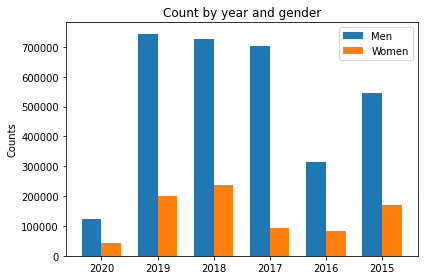

In [ ]:
x = np.arange(len(years))  # the years locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, M, width, label='Men')
rects2 = ax.bar(x + width/2, F, width, label='Women')

ax.set_ylabel('Counts')
ax.set_title('Count by year and gender')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()